# Save/Load Model 

In [ ]:
from keras.models import model_from_json
# Saving Model and weiths
# serialize model to JSON
model_json = model.to_json()
with open("hippo_model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("hippo_model.h5")
print("Saved model to disk")
 
# load json and create model
json_file = open('hippo_model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("hippo_model.h5")
print("Loaded model from disk")

# Evaluate

loaded_model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
score = loaded_model.evaluate(X, Y, verbose=0)
print("%s: %.2f%%" % (loaded_model.metrics_names[1], score[1]*100))



# HippoData

In [1]:
import numpy as np
from collections import Counter
from operator import itemgetter
from sklearn import metrics



# if you have labels


'''
    The idea of the function below (map_label) is a simplified approach to what they did in the initial paper. 
    They used the so called Hungarian method in order to optimize the labeling. The optimization is based on the
    ground truth and the labels from the k clustering. Using the example dataset:
    We have 20 000 items split in 20 categories, which means that a certain category has multiple items. 
    The idea of best mapping is to take all tuples from ground truth and prediction per item and count their 
    occurancies. For example (6, 18), 88), 6 being the ground truth and 18 the prediction truth. This 
    combination has occured 88 times but ((6, 3), 116) has occured 116 times, so at the end the function 
    will return 6,3 as best map.
'''

def map_label(true_labels, pred_labels):
    label_pair = list(zip(pred_labels, true_labels))
    count = tuple(Counter(label_pair).items())  #count the appearance of each pair dict principle
    mapping = dict()
    n_label = len(np.unique(true_labels))

    # map most likely labels from prediction to ground truth

    for label in range(n_label):
        tuples = [tup for tup in count if tup[0][0] == label]
        likely_tuple = max(tuples, key=itemgetter(1))[0] # tuple as input and take the one which appears the most from the list
        mapping[likely_tuple[0]] = likely_tuple[1]

    pred_labels_mapped = [mapping[x] for x in pred_labels]
    return pred_labels_mapped

# if you have labels
def cluster_quality(true_labels, pred_labels, show=True):
    h, c, v = metrics.homogeneity_completeness_v_measure(true_labels, pred_labels)
    nmi = metrics.normalized_mutual_info_score(true_labels, pred_labels)
    rand = metrics.adjusted_rand_score(true_labels, pred_labels)
    pred_labels_mapped = map_label(true_labels, pred_labels)
    acc = metrics.accuracy_score(true_labels, pred_labels_mapped)
    '''
    # Prints the scores
    if show:
        print("Homogeneity: %0.3f" % h)
        print("Completeness: %0.3f" % c)
        print("V-measure: %0.3f" % v)
        print("NMI: %0.3f" % nmi)
        print("Rand score: %0.3f" % rand)
        print("Accuracy: %0.3f" % acc)
        '''
    return dict(
        homogeneity=round(h,3),
        completeness=round(c,3),
        vmeasure=round(v,3),
        nmi=round(nmi,3),
        rand=round(rand,3),
        accuracy=round(acc,3),
    )


In [2]:
import os

from gensim.models.keyedvectors import KeyedVectors
from keras.callbacks import ModelCheckpoint
from keras.optimizers import Adam

############################
# Loading Data
############################

EMBEDDING_FILE = 'data/GoogleNews-vectors-negative300.bin' # word vectors
#text_path = 'data/StackOverflow.txt'# data without labels
#text_path = 'data/data_NN.txt'# data without labels - Own Data
text_path = 'data/data_NN_Scrapped.txt'# data without labels - Own Data based on scrapping
#text_path = 'data/data_NN_no_noise_Scrappe.txt'# scrapped data, no noise based on dbscan
#label_path = 'data/StackOverflow_gnd.txt' # labels per row in the data file

with open(text_path) as f:
    data = [text.strip() for text in f]
'''
with open(label_path) as f:
    target = f.readlines()
    
target = [int(label.rstrip('\n')) for label in target] # the data has /n at the end of each row
'''
print("Total: %s short texts" % format(len(data), ","))

Using TensorFlow backend.


Total: 7,904 short texts


In [3]:
############################
# Preprocessing
############################

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import numpy as np

tokenizer = Tokenizer(char_level=False)
tokenizer.fit_on_texts(data)
sequences_full = tokenizer.texts_to_sequences(data) # replace words/tokens with numbers

word_index = tokenizer.word_index # get the coresponing word:number dict format
print('Found %s unique tokens.' % len(word_index))
MAX_NB_WORDS = len(word_index) # all words - len

seq_lens = [len(s) for s in sequences_full] # get the count of words/symbols in the sequence from above
print("Minumum length: %d" % min(seq_lens))
print("Average length: %d" % np.mean(seq_lens))
print("Max length: %d" % max(seq_lens))
MAX_SEQUENCE_LENGTH = max(seq_lens)

X = pad_sequences(sequences_full, maxlen=MAX_SEQUENCE_LENGTH) # uses the len of the list and max len
#y = target # we take the target values

'''
    pad_sequences is used to ensure that all sequences in a list have the same length. By default this 
    is done by padding 0 in the beginning of each sequence until each sequence has the same 
    length as the longest sequence.
'''

Found 1999 unique tokens.
Minumum length: 0
Average length: 31
Max length: 1068


'\n    pad_sequences is used to ensure that all sequences in a list have the same length. By default this \n    is done by padding 0 in the beginning of each sequence until each sequence has the same \n    length as the longest sequence.\n'

In [4]:
############################
# Preparing embedding matrix
############################


print('Preparing embedding matrix')
word2vec = KeyedVectors.load_word2vec_format(EMBEDDING_FILE, binary=True)

EMBEDDING_DIM = 300
nb_words = min(MAX_NB_WORDS, len(word_index)) + 1
embedding_matrix = np.zeros((nb_words, EMBEDDING_DIM)) # Init as 0's and updated if in word2vec
for word, i in word_index.items():
    if word in word2vec.vocab:
        embedding_matrix[i] = word2vec.word_vec(word)
    #else:
        #print(word)
print('Null word embeddings: %d' % np.sum(np.sum(embedding_matrix, axis=1) == 0))

Preparing embedding matrix
Null word embeddings: 193


In [5]:
#################################################
# Preparing target using Average embeddings (AE)
#################################################
Y = {}
tfidf_seq = tokenizer.sequences_to_matrix(sequences_full, mode='tfidf') # converting List of sequences (a sequence is a list of integer word indices).
# TF-IDF Acc: 0,329
binary_seq = tokenizer.sequences_to_matrix(sequences_full, mode='binary') # Acc: 0,458
count_seq = tokenizer.sequences_to_matrix(sequences_full, mode='count') # Acc: 0,467
frequency_seq = tokenizer.sequences_to_matrix(sequences_full, mode='freq') # Acc: 0452
from sklearn.preprocessing import Normalizer
normed_value = Normalizer().fit_transform(count_seq)
average_embeddings = np.dot(normed_value, embedding_matrix)
Y["ae"] = average_embeddings
print("Shape of average embedding: ", Y['ae'].shape)


# binary Y
from sklearn import preprocessing
reduction_name = "ae"
B = preprocessing.Binarizer().fit_transform(Y[reduction_name]) # binarizing the whole value list for ae key (which is the only key)

# Shape of last dimension in the CNN
TARGET_DIM = B.shape[1]

# Example of binarized target vector
print(B.shape)
print(B[1])

Shape of average embedding:  (7904, 300)
(7904, 300)
[1. 0. 0. 1. 0. 1. 1. 0. 1. 0. 0. 0. 0. 0. 0. 1. 1. 1. 0. 0. 1. 1. 0. 1.
 1. 0. 0. 1. 1. 0. 0. 0. 0. 1. 0. 0. 1. 0. 1. 1. 0. 1. 1. 1. 0. 0. 0. 1.
 1. 1. 0. 0. 0. 0. 1. 1. 1. 0. 1. 0. 1. 0. 0. 0. 0. 1. 0. 1. 1. 1. 0. 1.
 1. 0. 0. 0. 1. 1. 0. 1. 1. 1. 1. 1. 1. 0. 0. 1. 1. 1. 1. 0. 0. 0. 1. 0.
 1. 1. 1. 1. 1. 0. 0. 1. 1. 0. 0. 1. 1. 0. 0. 1. 0. 0. 1. 1. 0. 0. 1. 0.
 0. 0. 0. 1. 1. 0. 0. 1. 0. 1. 0. 1. 0. 1. 1. 1. 1. 1. 1. 0. 1. 0. 0. 1.
 1. 0. 1. 0. 0. 0. 1. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 1. 1. 1. 0.
 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 1. 0. 0. 0.
 1. 0. 0. 1. 1. 0. 0. 0. 1. 1. 0. 1. 0. 0. 0. 0. 0. 1. 0. 1. 0. 1. 0. 1.
 1. 0. 0. 1. 0. 1. 0. 0. 0. 1. 1. 0. 1. 0. 0. 0. 1. 0. 0. 0. 1. 1. 1. 1.
 1. 0. 0. 0. 1. 1. 0. 1. 0. 0. 1. 1. 0. 1. 1. 0. 0. 0. 0. 0. 1. 0. 1. 1.
 0. 1. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 0. 1. 1. 0. 0. 1. 1. 1. 0. 1. 0. 1.
 1. 1. 1. 1. 0. 0. 0. 0. 1. 0. 1. 0.]


In [6]:
###############PLAYING-GridSearch#################################
# Playing train model
################################################

# Best accuracy for now

import keras
from keras.datasets import imdb
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential, Model
from keras.layers import Dense, Flatten, Dropout, Activation, concatenate, Input
from keras.layers import Embedding, Conv1D, SpatialDropout1D, GlobalMaxPooling1D
from keras.callbacks import ModelCheckpoint
from keras.utils.vis_utils import plot_model

#https://stats.stackexchange.com/questions/240305/where-should-i-place-dropout-layers-in-a-neural-network
# the above link has to do with dropout positioning

# https://github.com/keras-team/keras/issues/7290
# has to do with spatial dropout after embedding layer

# https://towardsdatascience.com/review-tompson-cvpr15-spatial-dropout-human-pose-estimation-c7d6a5cecd8c
# SpatialDropout again

def get_model():
    embedding_matrix_copy = embedding_matrix.copy()
    trainable_embedding = False
    #filters = [2,3,4]
    filters = [3,4,5]
    
    # Embedding layer
    pretrained_embedding_layer = Embedding(
        input_dim=nb_words,
        output_dim=EMBEDDING_DIM,
        weights=[embedding_matrix],
        input_length=MAX_SEQUENCE_LENGTH,
    )

    # Input
    sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
    embedded_sequences = pretrained_embedding_layer(sequence_input)
    
    # DropOut
    #x = Dropout(0.2)(embedded_sequences)
    spatial_x = SpatialDropout1D(0.1)(embedded_sequences)
    
    # 1st Layer
    conv_layers = []
    for i in filters:
        x = Conv1D(125, i, activation='tanh', padding='same')(spatial_x)
        x = GlobalMaxPooling1D()(x)
        #x = Dropout(0.2)(x)
        conv_layers.append(x)
    merged = concatenate(conv_layers)
    
    # Dense
    #x = Dense(TARGET_DIM,activation = 'tanh')(merged)
    x = Dense(256,activation = 'tanh')(merged) # best performing
    
    # DropOut
    x = Dropout(0.1)(x)
    #x = Dropout(0.1)(merged) # best performing
    
    # Output
    predictions = Dense(TARGET_DIM, activation='sigmoid')(x) 
    # sigmoid because we want 0,1 for one of the categories
    
    model = Model(sequence_input, predictions)

    model.layers[1].trainable=trainable_embedding #embedding layer

    #adam = Adam(lr=1e-3, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
    adam = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0) #standard for keras
    #optimizer = Adam(lr=learn_rate)
    
    # Loss and Optimizer
    model.compile(loss='binary_crossentropy',
                  optimizer=adam,
                  metrics=['accuracy','mae'])
    
    # Fine-tune embeddings or not
    model.summary()
    plot_model(model, to_file='model_plot_no_shapes.png', show_shapes=False, show_layer_names=True)

    
    return model

In [7]:
from sklearn.preprocessing import normalize
# 25 epoch and 80 batch = 50.3 accuracy
nb_epoch = 8 #changed from 50 cause of time limitations

# 5 epochs take 1 hour and 14 mins to load

checkpoint = ModelCheckpoint('models/weights.{epoch:03d}-{val_acc:.4f}.hdf5', monitor='val_acc', verbose=1, save_best_only=True, mode='auto')
model = get_model()
history = model.fit(X, B, validation_split=0.2,
              epochs=nb_epoch, batch_size=100, verbose=1, shuffle=True)


Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 1068)         0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 1068, 300)    600000      input_1[0][0]                    
__________________________________________________________________________________________________
spatial_dropout1d_1 (SpatialDro (None, 1068, 300)    0           embedding_1[0][0]                
__________________________________________________________________________________________________
conv1d_1 (Conv1D)    

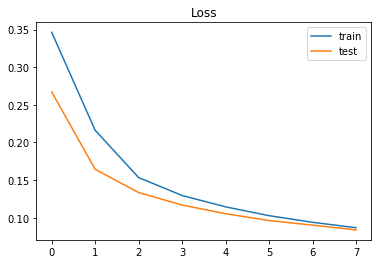

In [10]:
import matplotlib.pyplot as plt
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show();

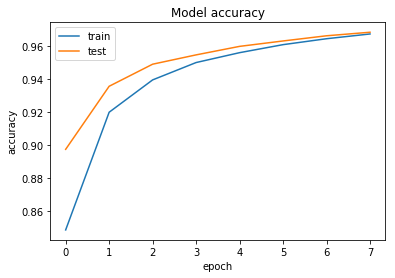

In [9]:
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [11]:
# create model that gives penultimate layer (предпоследно)
input1 = model.layers[0].input
output = model.layers[-2].output

model_penultimate = Model(input1, output)


# inference of penultimate layer
H_penul = model_penultimate.predict(X)
print("Sample shape: {}".format(H_penul.shape))
V_penul = normalize(H_penul, norm='l2') # nomr

# standard model prediction
H_standard = model.predict(X)
print("Sample shape for standard: {}".format(H_standard.shape))
V_standard = normalize(H_standard, norm='l2') # norm

Sample shape: (7904, 256)
Sample shape for standard: (7904, 300)


In [12]:
H_standardandard[1]

array([9.97244000e-01, 5.13699651e-03, 2.63214111e-04, 9.98127878e-01,
       2.43866444e-03, 9.99969721e-01, 9.99925971e-01, 3.09813023e-03,
       9.99932945e-01, 3.57773900e-03, 1.22898817e-03, 5.53965569e-04,
       4.88905311e-02, 3.72198224e-03, 1.11103058e-03, 9.99233603e-01,
       9.99672592e-01, 9.99935448e-01, 6.83915615e-03, 7.10487366e-04,
       9.99781847e-01, 9.99836087e-01, 3.55488062e-03, 9.99940991e-01,
       9.95442152e-01, 1.26287341e-03, 9.53048468e-04, 9.99605894e-01,
       9.99195933e-01, 2.00897455e-04, 4.53114510e-04, 6.29007816e-03,
       1.07038021e-03, 9.55791593e-01, 3.88562679e-02, 3.74883413e-04,
       9.99344587e-01, 1.50433183e-03, 9.99783099e-01, 9.98194814e-01,
       1.04889274e-02, 9.98557508e-01, 9.99649227e-01, 9.99798894e-01,
       3.83958220e-03, 1.67727470e-04, 2.78204679e-04, 9.97981310e-01,
       9.97822702e-01, 9.97825027e-01, 5.28600812e-03, 4.64230776e-04,
       8.16226006e-04, 1.82956457e-04, 9.94928300e-01, 9.99509513e-01,
      

In [13]:
V_standard[1]

array([8.43707174e-02, 4.34609858e-04, 2.22689359e-05, 8.44454989e-02,
       2.06320488e-04, 8.46013278e-02, 8.45976248e-02, 2.62113870e-04,
       8.45982134e-02, 3.02690634e-04, 1.03977174e-04, 4.68676408e-05,
       4.13632905e-03, 3.14894161e-04, 9.39975071e-05, 8.45390484e-02,
       8.45761895e-02, 8.45984221e-02, 5.78619190e-04, 6.01099928e-05,
       8.45854282e-02, 8.45900178e-02, 3.00756714e-04, 8.45988914e-02,
       8.42182711e-02, 1.06843996e-04, 8.06316020e-05, 8.45705420e-02,
       8.45358595e-02, 1.69967061e-05, 3.83352490e-05, 5.32165053e-04,
       9.05583292e-05, 8.08636844e-02, 3.28739127e-03, 3.17165941e-05,
       8.45484361e-02, 1.27272317e-04, 8.45855325e-02, 8.44511613e-02,
       8.87404021e-04, 8.44818428e-02, 8.45742077e-02, 8.45868737e-02,
       3.24843568e-04, 1.41903956e-05, 2.35371972e-05, 8.44331011e-02,
       8.44196752e-02, 8.44198763e-02, 4.47216822e-04, 3.92757283e-05,
       6.90558954e-05, 1.54788268e-05, 8.41748044e-02, 8.45623910e-02,
      

In [14]:
from sklearn.decomposition import PCA
# Make an instance of the Model
pca = PCA(.95)
pca.fit(H_standard)
PCA_standard = pca.transform(H_standard)

In [18]:
PCA_standard[1]

array([-3.3273206 , -1.4959846 , -0.03390983, -0.33551955,  0.11630808,
       -1.32335   ,  1.7992699 ,  1.1690254 , -0.02543197, -0.7554288 ,
       -0.12492372,  0.43684214,  0.06940129,  0.10306479,  0.18653876,
        0.28004047,  0.20712374,  0.19100538, -0.11310594,  0.39471012],
      dtype=float32)

In [219]:
import numpy as np
import scipy
import matplotlib.pyplot as plt

anomalies = []

# multiply and add by random numbers to get some real values
#data = np.random.randn(50000)  * 20 + 20

# Function to Detection Outlier on one-dimentional datasets.
def find_anomalies(random_data):
    # Set upper and lower limit to 3 standard deviation
    random_data_std = scipy.std(random_data)
    random_data_mean = scipy.mean(random_data)
    anomaly_cut_off = random_data_std * 3
    
    lower_limit  = random_data_mean - anomaly_cut_off 
    upper_limit = random_data_mean + anomaly_cut_off
    print(lower_limit)
    # Generate outliers
    
    for outlier in random_data:
        if (outlier > upper_limit).any() or (outlier < lower_limit).any():
            continue
        else:
            anomalies.append(outlier)
    '''
    for outlier in range(len(random_data)):
        if (random_data[outlier] > upper_limit).any() or (random_data[outlier] < lower_limit).any():
            anomalies.append(outlier)
            '''
    return anomalies

test = find_anomalies(PCA_standard)

-3.6609005069925615


In [220]:
len(test)

5722

In [192]:
new_a = np.delete(V_standard, test)

In [193]:
len(V_standard)

7904

In [200]:
V_standard

array([[8.60237330e-02, 3.01365289e-05, 2.08306028e-05, ...,
        2.10537601e-05, 8.56917202e-02, 2.22947216e-04],
       [8.43707174e-02, 4.34609858e-04, 2.22689359e-05, ...,
        2.05140477e-05, 8.42410848e-02, 2.26202933e-03],
       [8.77443776e-02, 2.55403556e-05, 3.05991998e-05, ...,
        9.99724034e-06, 8.72157514e-02, 1.45742903e-04],
       ...,
       [8.77698213e-02, 3.48919311e-05, 5.51646044e-05, ...,
        1.37211055e-05, 8.71323869e-02, 1.39324198e-04],
       [8.56798589e-02, 2.65265098e-05, 2.22548806e-05, ...,
        1.68642491e-05, 8.51778388e-02, 1.44514939e-04],
       [2.07379647e-03, 8.62807110e-02, 8.39163214e-02, ...,
        2.34140840e-04, 2.35597929e-03, 2.56371149e-03]], dtype=float32)

In [199]:
type(V_standard[1])

numpy.ndarray

In [197]:
type(V_standard)

numpy.ndarray

In [194]:
len(new_a)

2370177

In [215]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
from sklearn.metrics import pairwise_distances
from scipy.spatial.distance import pdist

anomalies = []

# multiply and add by random numbers to get some real values
#data = np.random.randn(50000)  * 20 + 20

# Function to Detection Outlier on one-dimentional datasets.
def find_anomalies(random_data):
    # Set upper and lower limit to 3 standard deviation
    #pair_dist = pairwise_distances(random_data, metric='euclidean', n_jobs=-1)
    p_dist = pdist(random_data, metric='euclidean')
    lower_limit  = p_dist.argmin()
    upper_limit  = p_dist.argmax()
    treshhold =(lower_limit + upper_limit)/2
    print(lower_limit)
    print(upper_limit)
    print(treshhold)
    # Generate outliers
    for outlier in random_data:
        if (outlier <= treshhold).all():
            anomalies.append(outlier)
    return anomalies

test = find_anomalies(H_standard)

110
39046
19578.0


In [216]:
len(test)

7904

In [145]:
from sklearn.metrics import pairwise_distances
from scipy.spatial.distance import pdist
test = pairwise_distances(V_standard, metric='euclidean')
#test = pdist(V_standard, metric='euclidean')

In [ ]:
# Amount of Clusters based on Penul data
# Wherever it makes the curve switch - around 6-7 for this data

import numpy as np
from scipy import cluster
from matplotlib import pyplot

#V = normalize(H, norm='l2') # https://machinelearningmastery.com/vector-norms-machine-learning/
#plot variance for each value for 'k' between 1,10
initial = [cluster.vq.kmeans(V_penul,i) for i in range(1,40)]
pyplot.plot([var for (cent,var) in initial])
pyplot.show()

In [ ]:
# Amount of Clusters based on standard prediction
# Wherever it makes the curve switch - around 6-7 for this data

import numpy as np
from scipy import cluster
from matplotlib import pyplot

#V = normalize(H, norm='l2') # https://machinelearningmastery.com/vector-norms-machine-learning/
#plot variance for each value for 'k' between 1,10
initial = [cluster.vq.kmeans(V_standard,i) for i in range(1,40)]
pyplot.plot([var for (cent,var) in initial])
pyplot.show()

In [ ]:
# Penul Layer

from sklearn.preprocessing import normalize
from sklearn.cluster import KMeans

#№true_labels = y
#n_clusters = len(np.unique(y))
n_clusters = 27 # for own data
print("Number of classes: %d" % n_clusters)
km = KMeans(n_clusters=n_clusters, n_jobs=10)
result_penul = dict()
#V_penul = normalize(H_penul, norm='l2') # https://machinelearningmastery.com/vector-norms-machine-learning/
km.fit(V_penul)
pred_penul = km.labels_
pred1_penul = km.cluster_centers_
print(pred_penul)
#a = cluster_quality(true_labels, pred_penul) #needs labels
#np.save("pred.npy", pred)
#print(a)

In [ ]:
# Penul Layer

from sklearn.preprocessing import normalize
from sklearn.cluster import KMeans

#№true_labels = y
#n_clusters = len(np.unique(y))
n_clusters = 27 # for own data
print("Number of classes: %d" % n_clusters)
km = KMeans(n_clusters=n_clusters, n_jobs=10)
result_penul = dict()
#V_penul = normalize(H_penul, norm='l2') # https://machinelearningmastery.com/vector-norms-machine-learning/
km.fit(V_standard)
pred_standard = km.labels_
pred1_standard = km.cluster_centers_
print(pred_standard)
#a = cluster_quality(true_labels, pred_penul) #needs labels
#np.save("pred.npy", pred)
#print(a)

# DBSCAN - Penul and Standard Layer

In [ ]:
#################################################
################Visualization####################
#################################################

In [ ]:

# DBSCAN for penul layer based on scrapped keywords

import numpy as np
from sklearn.cluster import DBSCAN
from sklearn import metrics
from sklearn.datasets.samples_generator import make_blobs
from sklearn.preprocessing import StandardScaler


# #############################################################################


X = StandardScaler().fit_transform(V_penul)

# #############################################################################
# Compute DBSCAN
db = DBSCAN(eps=0.3, min_samples= 10).fit(V_penul)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print('Estimated number of clusters: %d' % n_clusters_)
print('Estimated number of noise points: %d' % n_noise_)
print("Homogeneity: %0.3f" % metrics.homogeneity_score(pred_penul, labels))
print("Completeness: %0.3f" % metrics.completeness_score(pred_penul, labels))
print("V-measure: %0.3f" % metrics.v_measure_score(pred_penul, labels))
print("Adjusted Rand Index: %0.3f"
      % metrics.adjusted_rand_score(pred_penul, labels))
print("Adjusted Mutual Information: %0.3f"
      % metrics.adjusted_mutual_info_score(pred_penul, labels,
                                           average_method='arithmetic'))
print("Silhouette Coefficient: %0.3f"
      % metrics.silhouette_score(X, labels))

# #############################################################################
# Plot result - DBSCAN
import matplotlib.pyplot as plt

# Black removed and is used for noise instead.
unique_labels = set(labels)
colors = [plt.cm.Spectral(each)
          for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = (labels == k)

    xy = X[class_member_mask & core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o',
             markeredgecolor='k', markersize=14)

    #xy = X[class_member_mask & ~core_samples_mask]
    #plt.plot(xy[:, 0], xy[:, 1], 'o',
     #        markeredgecolor='k', markersize=6)

plt.title('Estimated number of clusters: %d' % n_clusters_)
plt.show()

In [ ]:

# DBSCAN for standard prediction based on scrapped keywords

import numpy as np

from sklearn.cluster import DBSCAN
from sklearn import metrics
from sklearn.datasets.samples_generator import make_blobs
from sklearn.preprocessing import StandardScaler


# #############################################################################


X = StandardScaler().fit_transform(V_standard)

# #############################################################################
# Compute DBSCAN
db = DBSCAN(eps=0.3, min_samples= 10).fit(V_standard)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print('Estimated number of clusters: %d' % n_clusters_)
print('Estimated number of noise points: %d' % n_noise_)
print("Homogeneity: %0.3f" % metrics.homogeneity_score(pred_standard, labels))
print("Completeness: %0.3f" % metrics.completeness_score(pred_standard, labels))
print("V-measure: %0.3f" % metrics.v_measure_score(pred_standard, labels))
print("Adjusted Rand Index: %0.3f"
      % metrics.adjusted_rand_score(pred_standard, labels))
print("Adjusted Mutual Information: %0.3f"
      % metrics.adjusted_mutual_info_score(pred_standard, labels,
                                           average_method='arithmetic'))
print("Silhouette Coefficient: %0.3f"
      % metrics.silhouette_score(X, labels))

# #############################################################################
# Plot result
import matplotlib.pyplot as plt

# Black removed and is used for noise instead.
unique_labels = set(labels)
colors = [plt.cm.Spectral(each)
          for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = (labels == k)

    xy = X[class_member_mask & core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o',
             markeredgecolor='k', markersize=14)

    xy = X[class_member_mask & ~core_samples_mask]
    #plt.plot(xy[:, 0], xy[:, 1], 'o',
     #        markeredgecolor='k', markersize=6)

plt.title('Estimated number of clusters: %d' % n_clusters_)
plt.show()

In [ ]:
len(labels)

# Silhoette - Penul and Standard With Noise

In [ ]:
#################################################
################Evaluation####################
#################################################

For n_clusters = 2 The average silhouette_score is : 0.39586693


KeyboardInterrupt: 

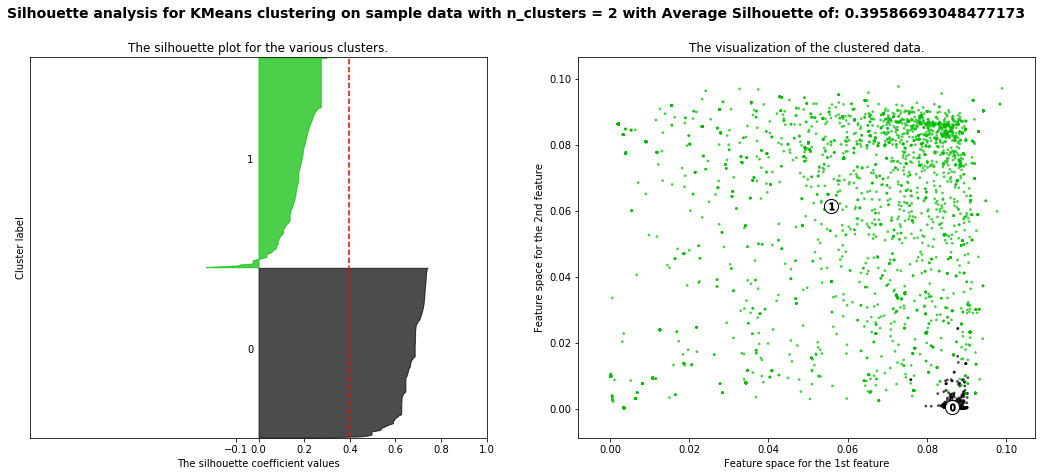

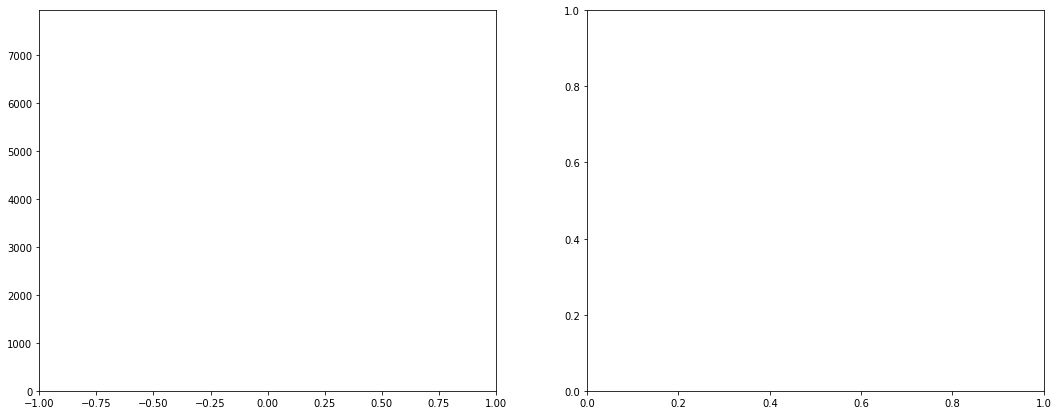

In [21]:

# Running the results from standard prediction based on Scrapped Keywords

from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np

#print(__doc__)
from matplotlib.backends.backend_pdf import PdfPages
# Generating the sample data from make_blobs
# This particular setting has one distinct cluster and 3 clusters placed close
# together.

pp = PdfPages('ScrappedKeywords_StandardPrediction100_WorkingOnEval.pdf')


range_n_clusters = []
for i in range(2,101): # make a list from 1 till 31
    range_n_clusters.append(i)

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(V_standard) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(V_standard)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(V_standard, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(V_standard, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(V_standard[:, 0], V_standard[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors, edgecolor='k')

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = {} with Average Silhouette of: {}".format(n_clusters,silhouette_avg)),
                 fontsize=14, fontweight='bold')
    pp.savefig(fig)

plt.show()
pp.close()

In [ ]:

# Running the results from penul layer from Scrappe Keywords

from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np

#print(__doc__)
from matplotlib.backends.backend_pdf import PdfPages
# Generating the sample data from make_blobs
# This particular setting has one distinct cluster and 3 clusters placed close
# together.

pp = PdfPages('ScrappedKeywords_PenulLayer100_WorkingOnEval.pdf')


range_n_clusters = []
for i in range(2,101): # make a list from 1 till 31
    range_n_clusters.append(i)

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(V_penul) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(V_penul)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(V_penul, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(V_penul, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(V_penul[:, 0], V_penul[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors, edgecolor='k')

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = {} with Average Silhouette of: {}".format(n_clusters,silhouette_avg)),
                 fontsize=14, fontweight='bold')
    pp.savefig(fig)

plt.show()
pp.close()

# GLS - Standard and Penul Layers - with noise (BIT STRANGE)

In [ ]:
# https://medium.com/@mchenebaux/choosing-the-right-number-of-clusters-using-the-gaussian-likelihood-score-30bce5ad6eac

In [ ]:
# Standard Layer
from gls import gaussian_likelihood_score, find_best_cluster
from sklearn.cluster import AgglomerativeClustering

# get score for each possible k
gls_scores = []
#gls_scores_dict = {}
for i in range(2, 50):
    clusterer = AgglomerativeClustering(n_clusters=i).fit(V_standard)
    labels = clusterer.labels_
    # append score for the hypothesis `i`
    gls_scores.append(gaussian_likelihood_score(V_standard, labels))
    #gls_scores_dict[i] = gaussian_likelihood_score(V_standard, labels)
    
# find best cluster. `+ 2` because we start with i == 2
guess = find_best_cluster(gls_scores) + 2
print(f"GLS guess: {guess}")
#print("GLS score: {}".format(gls_scores_dict[guess]))


In [ ]:
# Penul Layer
from gls import gaussian_likelihood_score, find_best_cluster
from sklearn.cluster import AgglomerativeClustering

# get score for each possible k
gls_scores = []
for i in range(2, 50):
    clusterer = AgglomerativeClustering(n_clusters=i).fit(V_penul)
    labels = clusterer.labels_
    # append score for the hypothesis `i`
    gls_scores.append(gaussian_likelihood_score(V_penul, labels))

# find best cluster. `+ 2` because we start with i == 2
guess = find_best_cluster(gls_scores) + 2
print(f"GLS guess: {guess}")

In [74]:
import seaborn as sns
def optimal_kmeans(dataset, start=2, end=51):
    '''
    Calculate the optimal number of kmeans
    
    INPUT:
        dataset : dataframe. Dataset for k-means to fit
        start : int. Starting range of kmeans to test
        end : int. Ending range of kmeans to test
    OUTPUT:
        Values and line plot of Silhouette Score.
    '''
    
    # Create empty lists to store values for plotting graphs
    n_clu = []
    km_ss = []

    # Create a for loop to find optimal n_clusters
    for n_clusters in range(start, end):

        # Create cluster labels
        kmeans = KMeans(n_clusters=n_clusters)
        labels = kmeans.fit_predict(dataset)

        # Calcualte model performance
        silhouette_avg = round(silhouette_score(dataset, labels, random_state=1), 3)

        # Append score to lists
        km_ss.append(silhouette_avg)
        n_clu.append(n_clusters)

        print("No. Clusters: {}, Silhouette Score: {}, Change from Previous Cluster: {}".format(
            n_clusters, 
            silhouette_avg, 
            (km_ss[n_clusters - start] - km_ss[n_clusters - start - 1]).round(3)))

        # Plot graph at the end of loop
        if n_clusters == end - 1:
            plt.figure(figsize=(6.47,3))

            plt.title('Silhouette Score')
            sns.pointplot(x=n_clu, y=km_ss)
            plt.savefig('silhouette_score.png', format='png', dpi=1000)
            plt.tight_layout()
            plt.show()

No. Clusters: 2, Silhouette Score: 0.414000004529953, Change from Previous Cluster: 0.0
No. Clusters: 3, Silhouette Score: 0.5559999942779541, Change from Previous Cluster: 0.1420000046491623
No. Clusters: 4, Silhouette Score: 0.5609999895095825, Change from Previous Cluster: 0.004999999888241291
No. Clusters: 5, Silhouette Score: 0.5770000219345093, Change from Previous Cluster: 0.01600000075995922
No. Clusters: 6, Silhouette Score: 0.5979999899864197, Change from Previous Cluster: 0.020999999716877937
No. Clusters: 7, Silhouette Score: 0.6079999804496765, Change from Previous Cluster: 0.009999999776482582
No. Clusters: 8, Silhouette Score: 0.5040000081062317, Change from Previous Cluster: -0.10400000214576721
No. Clusters: 9, Silhouette Score: 0.5199999809265137, Change from Previous Cluster: 0.01600000075995922
No. Clusters: 10, Silhouette Score: 0.4740000069141388, Change from Previous Cluster: -0.04600000008940697
No. Clusters: 11, Silhouette Score: 0.48500001430511475, Change fro

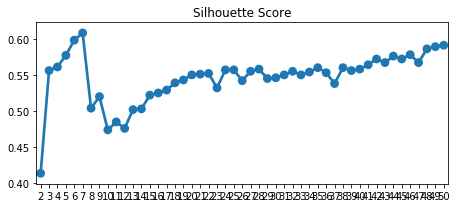

In [222]:
optimal_kmeans(PCA_standard)

In [ ]:
from sklearn.decomposition import PCA
# Make an instance of the Model
pca = PCA(.95)
pca.fit(V_standard)
V_standard = pca.transform(V_standard)

In [ ]:
def kmeans(df, clusters_number):
    '''
    Implement k-means clustering on dataset
    
    INPUT:
        dataset : dataframe. Dataset for k-means to fit.
        clusters_number : int. Number of clusters to form.
        end : int. Ending range of kmeans to test.
    OUTPUT:
        Cluster results and t-SNE visualisation of clusters.
    '''
    
    kmeans = KMeans(n_clusters = clusters_number, random_state = 1)
    kmeans.fit(df)

    # Extract cluster labels
    cluster_labels = kmeans.labels_
        
    # Create a cluster label column in original dataset
    df_new = df.assign(Cluster = cluster_labels)
    '''
    # Initialise TSNE
    model = TSNE(random_state=1)
    transformed = model.fit_transform(df)
    
    # Plot t-SNE
    plt.title('Flattened Graph of {} Clusters'.format(clusters_number))
    sns.scatterplot(x=transformed[:,0], y=transformed[:,1], hue=cluster_labels, style=cluster_labels, palette="Set1")
    '''
    return df_new, cluster_labels

In [ ]:
type(V_standard)

In [ ]:
import pandas as pd
df = pd.DataFrame(data=V_standard)

#print(df)

In [ ]:
from sklearn.manifold import TSNE

In [ ]:
dfne,s= kmeans(df,9)

In [ ]:
dfne

In [ ]:
s

# Playing - Random

In [ ]:
import numpy as np
import pandas as pd
from scipy.spatial import distance 
from sklearn.utils import validation
from sklearn.metrics import pairwise
from scipy.sparse import issparse
# Vectorized Version
def gower_distances(X, Y=None, feature_weight=None, categorical_features=None):
    """Computes the gower distances between X and Y

    Gower is a similarity measure for categorical, boolean and numerical mixed
    data.

    
    Parameters
    ----------
    X : array-like, or pandas.DataFrame, shape (n_samples, n_features)

    Y : array-like, or pandas.DataFrame, shape (n_samples, n_features)

    feature_weight :  array-like, shape (n_features)
        According the Gower formula, feature_weight is an attribute weight.

    categorical_features: array-like, shape (n_features)
        Indicates with True/False whether a column is a categorical attribute.
        This is useful when categorical atributes are represented as integer
        values. Categorical ordinal attributes are treated as numeric, and must
        be marked as false.
        
        Alternatively, the categorical_features array can be represented only
        with the numerical indexes of the categorical attribtes.

    Returns
    -------
    similarities : ndarray, shape (n_samples, n_samples)

    Notes
    ------
    The non-numeric features, and numeric feature ranges are determined from X and not Y.
    No support for sparse matrices.

    """
    
    if issparse(X) or issparse(Y):
        raise TypeError("Sparse matrices are not supported for gower distance")
        
    y_none = Y is None
    
    
    # It is necessary to convert to ndarray in advance to define the dtype
    if not isinstance(X, np.ndarray):
        X = np.asarray(X)

    array_type = np.object
    # this is necessary as strangelly the validator is rejecting numeric
    # arrays with NaN
    if  np.issubdtype(X.dtype, np.number) and (np.isfinite(X.sum()) or np.isfinite(X).all()):
        array_type = type(np.zeros(1,X.dtype).flat[0])
    
    X, Y = check_pairwise_arrays(X, Y, precomputed=False, dtype=array_type)
    
    n_rows, n_cols = X.shape
    
    if categorical_features is None:
        categorical_features = np.zeros(n_cols, dtype=bool)
        for col in range(n_cols):
            # In numerical columns, None is converted to NaN,
            # and the type of NaN is recognized as a number subtype
            if not np.issubdtype(type(X[0, col]), np.number):
                categorical_features[col]=True
    else:          
        categorical_features = np.array(categorical_features)
    
    
    #if categorical_features.dtype == np.int32:
    if np.issubdtype(categorical_features.dtype, np.int):
        new_categorical_features = np.zeros(n_cols, dtype=bool)
        new_categorical_features[categorical_features] = True
        categorical_features = new_categorical_features
    
    print(categorical_features)
  
    # Categorical columns
    X_cat =  X[:,categorical_features]
    
    # Numerical columns
    X_num = X[:,np.logical_not(categorical_features)]
    ranges_of_numeric = None
    max_of_numeric = None
    
        
    # Calculates the normalized ranges and max values of numeric values
    _ ,num_cols=X_num.shape
    ranges_of_numeric = np.zeros(num_cols)
    max_of_numeric = np.zeros(num_cols)
    for col in range(num_cols):
        col_array = X_num[:, col].astype(np.float32) 
        max = np.nanmax(col_array)
        min = np.nanmin(col_array)
     
        if np.isnan(max):
            max = 0.0
        if np.isnan(min):
            min = 0.0
        max_of_numeric[col] = max
        ranges_of_numeric[col] = (1 - min / max) if (max != 0) else 0.0


    # This is to normalize the numeric values between 0 and 1.
    X_num = np.divide(X_num ,max_of_numeric,out=np.zeros_like(X_num), where=max_of_numeric!=0)

    
    if feature_weight is None:
        feature_weight = np.ones(n_cols)
        
    feature_weight_cat=feature_weight[categorical_features]
    feature_weight_num=feature_weight[np.logical_not(categorical_features)]
    
    
    y_n_rows, _ = Y.shape
    
    dm = np.zeros((n_rows, y_n_rows), dtype=np.float32)
        
    feature_weight_sum = feature_weight.sum()

    Y_cat=None
    Y_num=None
    
    if not y_none:
        Y_cat = Y[:,categorical_features]
        Y_num = Y[:,np.logical_not(categorical_features)]
        # This is to normalize the numeric values between 0 and 1.
        Y_num = np.divide(Y_num ,max_of_numeric,out=np.zeros_like(Y_num), where=max_of_numeric!=0)
    else:
        Y_cat=X_cat
        Y_num = X_num
        
    for i in range(n_rows):
        j_start= i
        
        # for non square results
        if n_rows != y_n_rows:
            j_start = 0

      
        Y_cat[j_start:n_rows,:]
        Y_num[j_start:n_rows,:]
        result= _gower_distance_row(X_cat[i,:], X_num[i,:],Y_cat[j_start:n_rows,:],
                                    Y_num[j_start:n_rows,:],feature_weight_cat,feature_weight_num,
                                    feature_weight_sum,categorical_features,ranges_of_numeric,
                                    max_of_numeric) 
        dm[i,j_start:]=result
        dm[i:,j_start]=result
        

    return dm

In [ ]:
def _gower_distance_row(xi_cat,xi_num,xj_cat,xj_num,feature_weight_cat,feature_weight_num,
                        feature_weight_sum,categorical_features,ranges_of_numeric,max_of_numeric ):
    # categorical columns
    sij_cat = np.where(xi_cat == xj_cat,np.zeros_like(xi_cat),np.ones_like(xi_cat))
    sum_cat = np.multiply(feature_weight_cat,sij_cat).sum(axis=1) 

    # numerical columns
    abs_delta=np.absolute( xi_num-xj_num)
    sij_num=np.divide(abs_delta, ranges_of_numeric, out=np.zeros_like(abs_delta), where=ranges_of_numeric!=0)

    sum_num = np.multiply(feature_weight_num,sij_num).sum(axis=1)
    sums= np.add(sum_cat,sum_num)
    sum_sij = np.divide(sums,feature_weight_sum)
    return sum_sij

In [ ]:

def check_pairwise_arrays(X, Y, precomputed=False, dtype=None):
    X, Y, dtype_float = pairwise._return_float_dtype(X, Y)

    warn_on_dtype = dtype is not None
    estimator = 'check_pairwise_arrays'
    if dtype is None:
        dtype = dtype_float

    if Y is X or Y is None:
        X = Y = validation.check_array(X, accept_sparse='csr', dtype=dtype,
                            warn_on_dtype=warn_on_dtype, estimator=estimator)
    else:
        X = validation.check_array(X, accept_sparse='csr', dtype=dtype,
                        warn_on_dtype=warn_on_dtype, estimator=estimator)
        Y = validation.check_array(Y, accept_sparse='csr', dtype=dtype,
                        warn_on_dtype=warn_on_dtype, estimator=estimator)

    if precomputed:
        if X.shape[1] != Y.shape[0]:
            raise ValueError("Precomputed metric requires shape "
                             "(n_queries, n_indexed). Got (%d, %d) "
                             "for %d indexed." %
                             (X.shape[0], X.shape[1], Y.shape[0]))
    elif X.shape[1] != Y.shape[1]:
        raise ValueError("Incompatible dimension for X and Y matrices: "
                         "X.shape[1] == %d while Y.shape[1] == %d" % (
                             X.shape[1], Y.shape[1]))

    return X, Y


In [ ]:
import time
import pandas as pd
#from kmodes.kmodes import KModes
from sklearn.metrics import silhouette_score, silhouette_samples

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np


range_n_clusters = range(28, 29)
# a is the pre-computed matrix using the gower coefficient, using the daisy function in R.
a = gower_distances(df)

for n_clusters in range_n_clusters:

    fig, (ax1) = plt.subplots(1, 1)
    fig.set_size_inches(18, 10)

    ax1.set_xlim([-0.1, 1])
    ax1.set_ylim([0, len(data_frame) + (n_clusters + 1) * 10])
    kmodes_cao = KMeans(n_clusters = n_clusters, random_state = 1)
    kmodes_cao.fit_predict(data_frame)

    column_names = list(data_frame.columns.values)
    clusters = pd.DataFrame(kmodes_cao.cluster_centroids_, columns=column_names)

    b = kmodes_cao.labels_
    silhouette_avg = silhouette_score(a, b, metric='precomputed')

    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    sample_silhouette_values = silhouette_samples(a, b, metric='precomputed')

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[b == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title(("Silhouette analysis for KModes clustering "
                  "with clusters = %d" % n_clusters))
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # Draw white circles at cluster centers

    plt.show()

# Save to Json/CSV. If you don't want to specify a path, simply put the filename.
# jsonTools.json_save(sortedData, "./dataFiles/testProduced", to_json=False)

# Storing Locally

In [ ]:
data[1]

In [ ]:
sequences_full[1]

In [ ]:
X[1]

In [ ]:
H_standard[1]

In [ ]:
V_standard[1]

In [ ]:
pred_standard[1]

In [ ]:
pred1_standard[1]

In [ ]:
import pandas as pd
d = []
for i in range(len(data)):
    d.append({'Keywords': data[i], 'Sequence_Full': sequences_full[i], 'Prediction':labels[i]})
d = pd.DataFrame(d)
d.sort_values('Prediction')
d.to_csv('CNN_Demo-HippoBased_Labels.csv')

In [ ]:
d.reset_index().plot.scatter(x='index', y='Prediction')

In [ ]:
d["Prediction"].value_counts().plot.bar()

In [ ]:
d.sort_values('Prediction')

# Outlier Check

In [40]:
centroids,labels_= kmeans(H_standard,7)

In [50]:
from numpy import vstack,array
import numpy as np
from numpy.random import rand
from scipy.cluster.vq import kmeans,vq
# data generation
#data = vstack((rand(150,2) + array([.5,.5]),rand(150,2)))
# computing K-Means with K = 2 (2 clusters)
centroids,_ = kmeans(V_standard,7)
# assign each sample to a cluster
idx,_ = vq(V_standard,centroids)

#Print number of elements per cluster
print(np.bincount(idx))

[ 872  185 2118 2506  556  645 1022]


In [32]:
idx.labels_

AttributeError: 'numpy.ndarray' object has no attribute 'labels_'

In [69]:
from sklearn.preprocessing import normalize
from sklearn.cluster import KMeans

n_clusters = 7 # for own data
print("Number of classes: %d" % n_clusters)
km = KMeans(n_clusters=n_clusters, n_jobs=10)
result_penul = dict()
#V_penul = normalize(H_penul, norm='l2') # https://machinelearningmastery.com/vector-norms-machine-learning/
km.fit(PCA_standard)
pred_penul = km.labels_
pred1_penul = km.cluster_centers_
print(pred_penul)
#a = cluster_quality(true_labels, pred_penul) #needs labels
#np.save("pred.npy", pred)
#print(a)
from collections import Counter, defaultdict
a = Counter(km.labels_)

Number of classes: 7
[1 3 3 ... 3 1 2]


In [70]:
from collections import defaultdict

d = defaultdict(list)
for i in range(len(X)):
    d[pred_penul[i]].append(PCA_standard[1])

In [71]:
a.keys()

dict_keys([1, 3, 0, 2, 4, 6, 5])

In [72]:
size_dict = {}
for i in a.keys():
    size_dict[i] = a[i]

In [73]:
size_dict

{1: 982, 3: 2553, 0: 1022, 2: 2935, 4: 192, 6: 122, 5: 98}

In [76]:
d.pop('5', None)

In [78]:
test = [i for i in d.values()]

In [80]:
type(test)

list

In [81]:
type(PCA_standard)

numpy.ndarray

In [84]:
testme = np.array(test)

In [85]:
testme

array([list([array([-3.3273206 , -1.4959846 , -0.03390983, -0.33551955,  0.11630808,
       -1.32335   ,  1.7992699 ,  1.1690254 , -0.02543197, -0.7554288 ,
       -0.12492372,  0.43684214,  0.06940129,  0.10306479,  0.18653876,
        0.28004047,  0.20712374,  0.19100538, -0.11310594,  0.39471012],
      dtype=float32), array([-3.3273206 , -1.4959846 , -0.03390983, -0.33551955,  0.11630808,
       -1.32335   ,  1.7992699 ,  1.1690254 , -0.02543197, -0.7554288 ,
       -0.12492372,  0.43684214,  0.06940129,  0.10306479,  0.18653876,
        0.28004047,  0.20712374,  0.19100538, -0.11310594,  0.39471012],
      dtype=float32), array([-3.3273206 , -1.4959846 , -0.03390983, -0.33551955,  0.11630808,
       -1.32335   ,  1.7992699 ,  1.1690254 , -0.02543197, -0.7554288 ,
       -0.12492372,  0.43684214,  0.06940129,  0.10306479,  0.18653876,
        0.28004047,  0.20712374,  0.19100538, -0.11310594,  0.39471012],
      dtype=float32), array([-3.3273206 , -1.4959846 , -0.03390983, -0.33551

# NoNoise

In [ ]:
importName = 'CNN_Demo-HippoBased_Labels.xls'
cluster_labels = pd.read_excel(importName)

In [ ]:
# Make for data Model using the scrapped keywords
keywords_list = cluster_labels["Keywords"].tolist()
data_NN_no_noise = []
for i in keywords_list:
    data_NN_no_noise.append(i)
with open('data_NN_no_noise_Scrappe.txt', 'w') as f:
    for item in data_NN_no_noise:
        f.write("%s\n" % item)